# Notebook d'inference

Ce notebook qui contient un script d'inférence est à transformer en webapp pour effectuer des prédictions,

Vous y trouverez toutes les ressources nécessaires pour remplir le stub de `app.py` avec les bonnes valeurs

In [1]:
# !pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, http://localhost:2225/simple/


In [2]:
import time
from pathlib import Path
from typing import Dict

from PIL import Image

In [3]:
MODEL_NAMES = ["yolov5s", "yolov5m", "yolov5l"]

In [4]:
def load_model(model_name: str) -> Dict:
    # Load model from torch
    model = torch.hub.load("ultralytics/yolov5", model_name, pretrained=True)
    # Evaluation mode + Non maximum threshold
    model = model.fuse().eval()
    # for autoshaping of PIL/cv2/np inputs and NMS
    model = model.autoshape()

    return model

In [5]:
model = load_model("yolov5s")

Using cache found in /home/fchouteau/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    641792  models.common.BottleneckCSP             [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv         

Model Summary: 232 layers, 7459581 parameters, 7459581 gradients


Fusing layers... 
Adding autoShape... 


In [6]:
img = Path("cats.jpg")
img = Image.open(img)
if img.mode == "RGBA":
    img = img.convert("RGB")

In [10]:
# Inference
t0 = time.time()
predictions = model(img, size=640)  # includes NMS
t1 = time.time()
classes = predictions.names

preds = predictions.xyxy[0].numpy()

In [11]:
preds

array([[     269.48,      335.55,      793.77,      884.52,     0.70609,          15],
       [     1492.1,      362.13,        2000,      780.11,     0.68338,          15],
       [     1553.8,      676.55,      1998.9,      1136.8,      0.5816,          15],
       [     753.95,      222.02,      1085.7,      543.06,     0.58031,          15],
       [          0,      365.59,      364.71,      910.63,     0.57467,          15],
       [     1449.8,       118.6,      1787.8,      486.44,     0.54745,          15],
       [     644.28,      411.95,      1190.1,      1078.1,     0.52368,          15]], dtype=float32)

In [66]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import  ImageDraw, ImageFont


def draw_preds(image, preds, class_names):

    image = image.copy()

    colors = plt.cm.get_cmap("viridis", len(class_names)).colors
    colors = (colors[:, :3] * 255.0).astype(np.uint8)

    font = ImageFont.truetype(font="arial.ttf", size=np.floor(3e-2 * image.size[1] + 0.5).astype("int32"))
    thickness = (image.size[0] + image.size[1]) // 300

    for i in range(len(preds)):
        box = preds[i, :4]
        score = float(preds[i, 4])
        class_idx = int(preds[i, 5])
        predicted_class = class_names[class_idx]

        label = "{} {:.2f}".format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        left, top, right, bottom = box
        top = max(0, np.floor(top + 0.5).astype("int32"))
        left = max(0, np.floor(left + 0.5).astype("int32"))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype("int32"))
        right = min(image.size[0], np.floor(right + 0.5).astype("int32"))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for r in range(thickness):
            draw.rectangle([left + r, top + r, right - r, bottom - r], outline=tuple(colors[class_idx]))
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=tuple(colors[class_idx]))
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return image

In [67]:
image_with_preds = draw_preds(img, preds, classes)

cat 0.71 (269, 336) (794, 885)
cat 0.68 (1492, 362) (2000, 780)
cat 0.58 (1554, 677) (1999, 1137)
cat 0.58 (754, 222) (1086, 543)
cat 0.57 (0, 366) (365, 911)
cat 0.55 (1450, 119) (1788, 486)
cat 0.52 (644, 412) (1190, 1078)


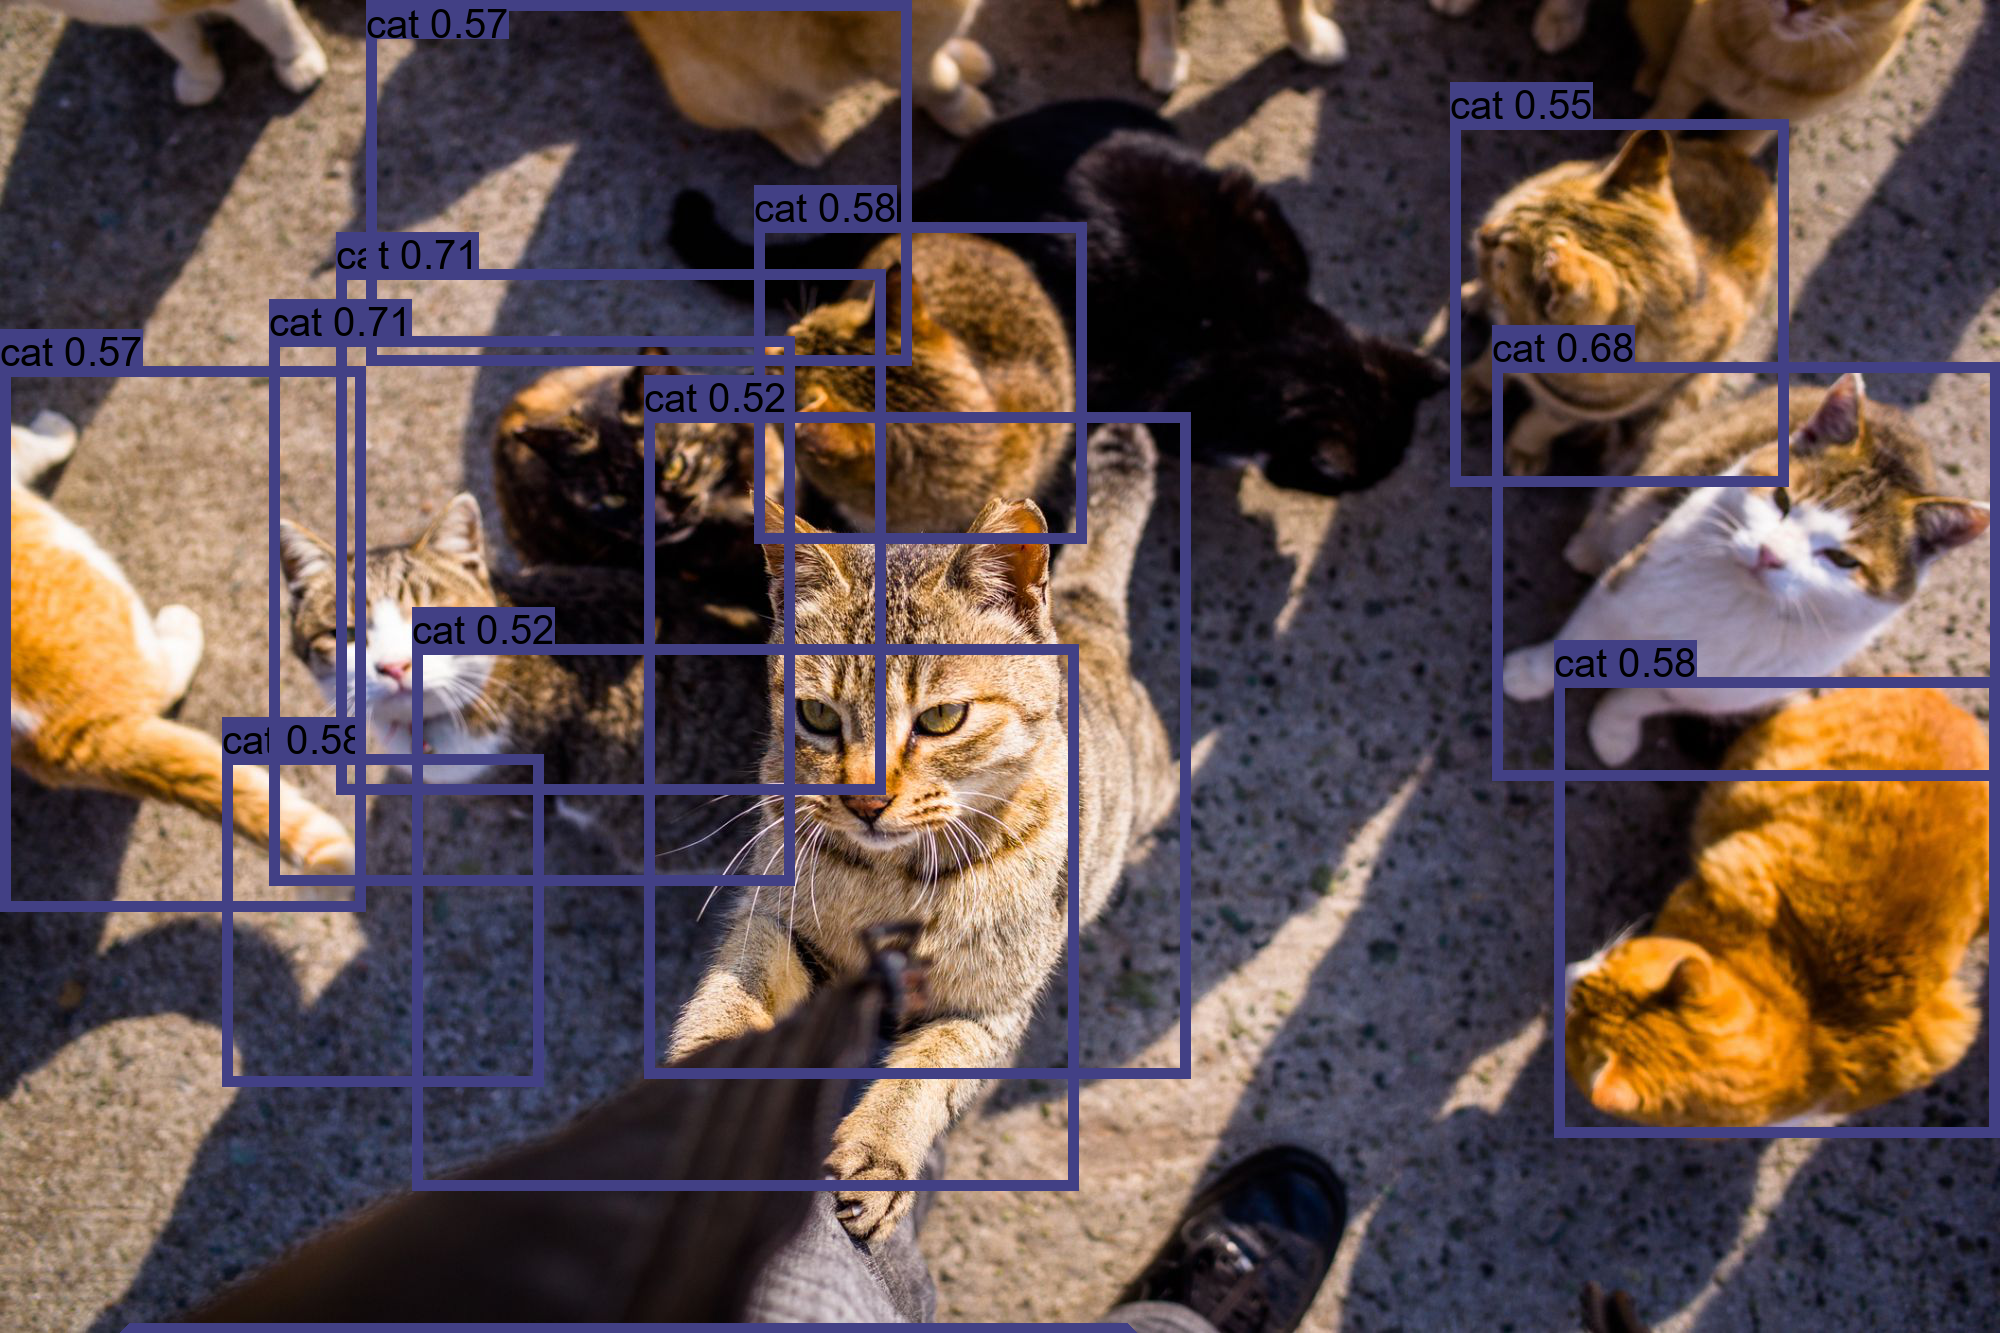

In [69]:
from IPython.display import display  # to display images

display(image_with_preds)